# Show Warpy Deformation from .json
Warpy produces a transformation file containing three realTransforms:
* Affine Transform
* ThinplateSpline Transform
* Affine Transform

This notebook inspects the ThinplateSpline Transform and calculates average shift and rotation.

In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
figuretype = 'png'

In [2]:
jsonfile = Path(r'transform.json')
with open(jsonfile) as f:
    data = json.load(f)
tps = data['realTransform_1']['wrappedTransform']['wrappedTransform']
srcPts = np.array(tps['srcPts'])
tgtPts = np.array(tps['tgtPts'])

In [3]:
df = pd.DataFrame()
df['x'] = srcPts[0]
df['y'] = srcPts[1]
df['dx'] = srcPts[0]-tgtPts[0]
df['dy'] = srcPts[1]-tgtPts[1]
df['displacement'] = np.sqrt(df['dx']**2+df['dy']**2)

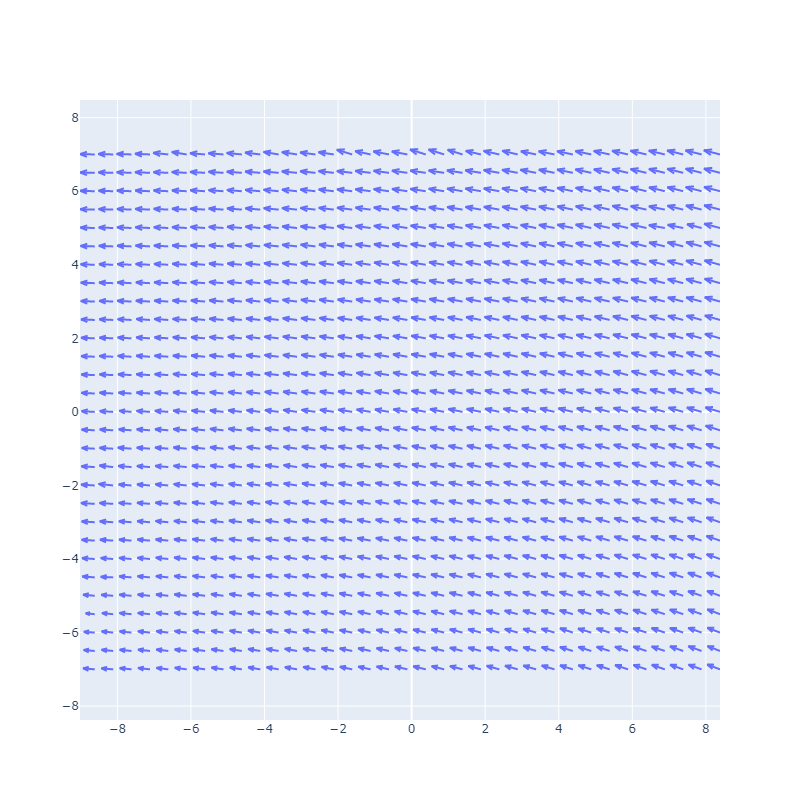

In [4]:
fig = ff.create_quiver(df['x'], df['y'], df['dx'], df['dy'],
                       scale=1,
                       arrow_scale=.5,
                       line_width=2)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )
fig.show(figuretype)

In [5]:
df['rdx'] = df['dx']-df['dx'].mean()
df['rdy'] = df['dy']-df['dy'].mean()
df['rdisplacement'] = np.sqrt(df['rdx']**2+df['rdy']**2)

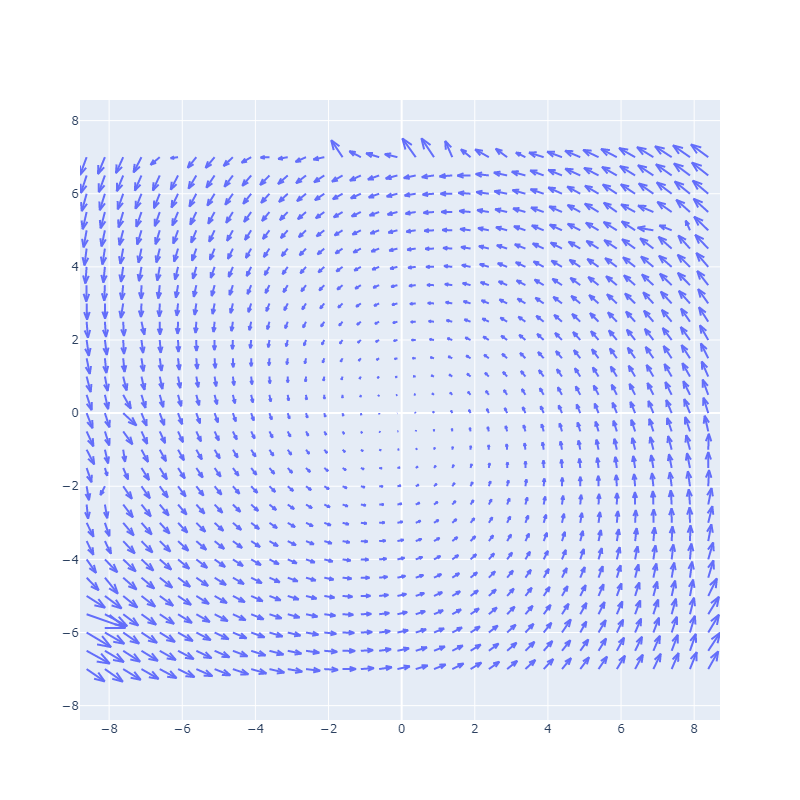

In [6]:
fig = ff.create_quiver(df['x'], df['y'], df['rdx'], df['rdy'],
                       scale=8,
                       arrow_scale=.5,
                       line_width=2)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )
fig.show(figuretype)

## Try to remove the rotation from the field?
* Transform to meshgrid data
* Calculate the average rotation (average curl)
* Remove from field

In [7]:
X,Y = np.meshgrid(df['x'][::29], df['y'][0:29])
dx = np.reshape(df['rdx'], np.flip(X.shape))
dy = np.reshape(df['rdy'], np.flip(X.shape))
disp = np.sqrt(dx**2 + dy**2)

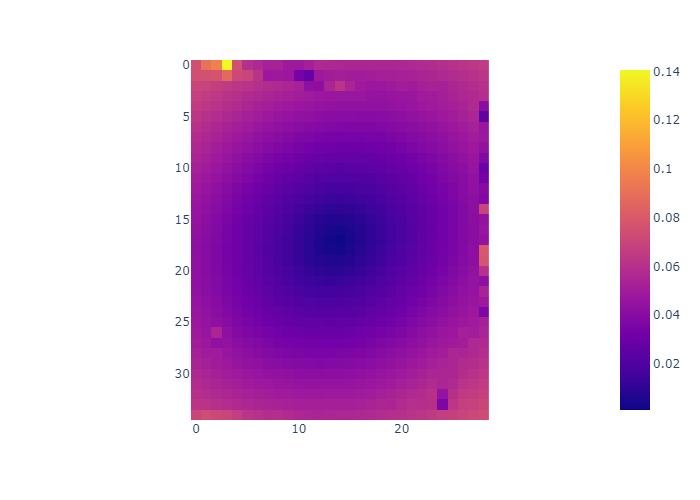

In [8]:
fig = px.imshow(disp)
fig.show(figuretype)
# Matches previous results well. So it seems to have worked.

In [9]:
def compute_curl(dx, dy, x, y):
    d_dy_dx = np.gradient(dy, axis=0)
    d_dx_dy = np.gradient(dx, axis=1)
    return d_dy_dx - d_dx_dy
curl = compute_curl(dx, dy, X, Y)

0.005966366617305068


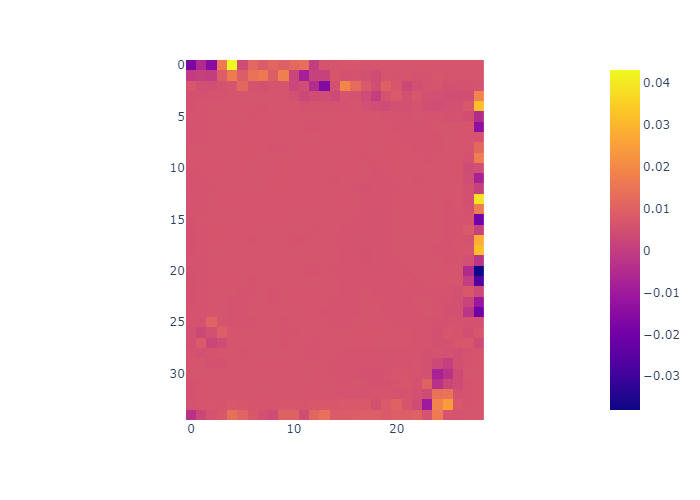

In [10]:
mcurl = curl.mean()
print(mcurl)
fig = px.imshow(curl)
fig.show(figuretype)

In [11]:
df['rrdx'] = df['rdx']-df['y']*mcurl
df['rrdy'] = df['rdy']-df['x']*mcurl
df['rrdisplacement'] = np.sqrt(df['rrdx']**2+df['rrdy']**2)

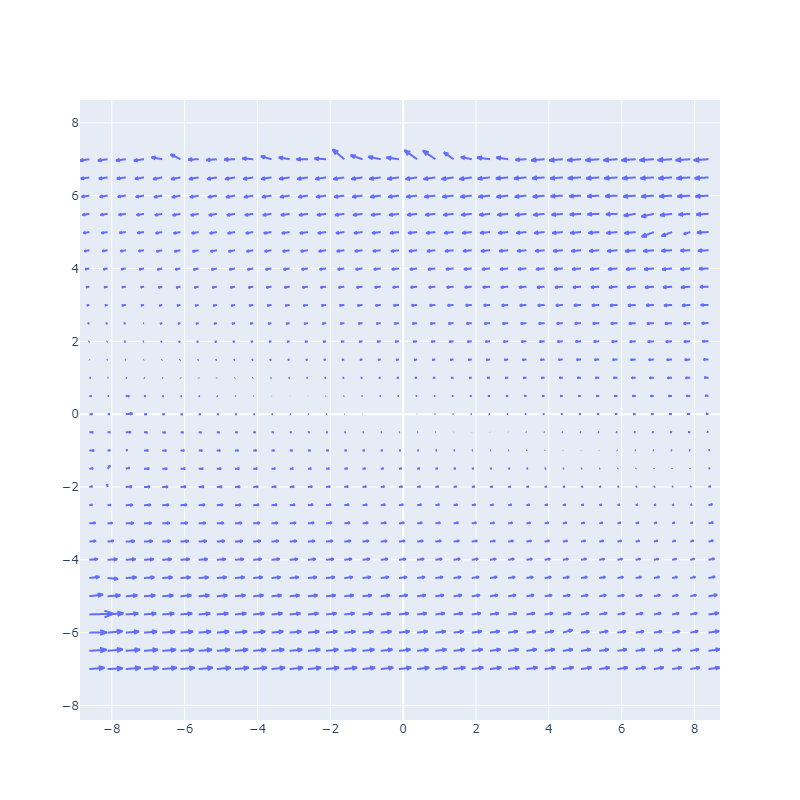

In [12]:
fig = ff.create_quiver(df['x'], df['y'], df['rrdx'], df['rrdy'],
                       scale=4,
                       arrow_scale=.4,
                       line_width=2)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )
fig.show(figuretype)

Max displacement: 0.16551995073097844


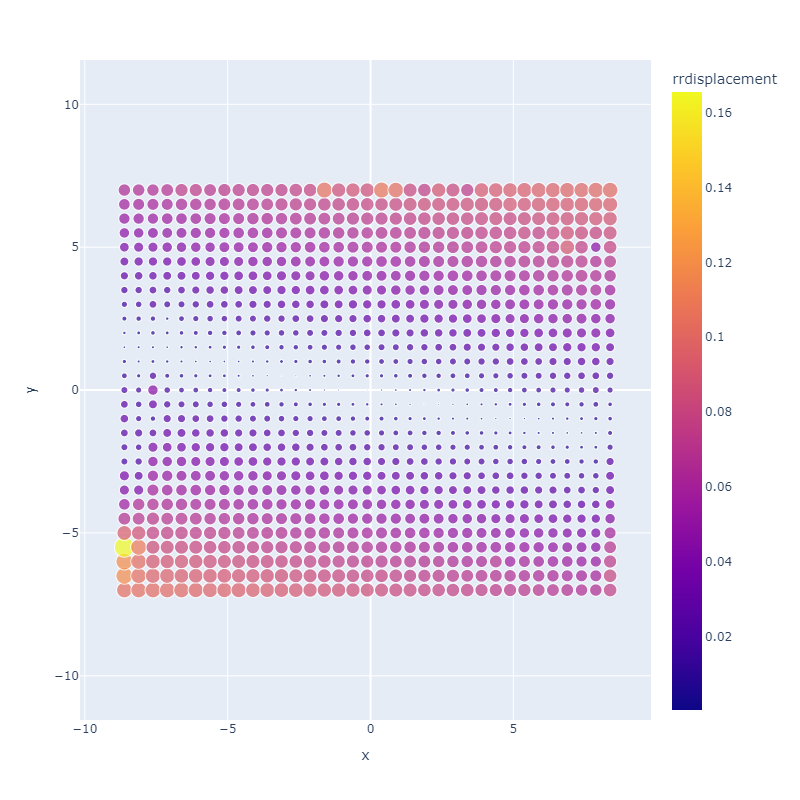

In [13]:
print(f"Max displacement: {df['rrdisplacement'].max()}")
fig = px.scatter(df, x="x", y="y", size='rrdisplacement', color='rrdisplacement', hover_data=['rrdx','rrdy'])
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )
fig.show(figuretype)

# Replacing TPS with affine

In [14]:
srcPts = np.transpose(np.array(tps['srcPts']))
tgtPts = np.transpose(np.array(tps['tgtPts']))
srcPts2 = np.hstack([srcPts, np.ones((srcPts.shape[0],1))])
tgtPts2 = tgtPts
affine = np.linalg.lstsq(srcPts2, tgtPts2)[0]

In [15]:
tgtPts_affine = np.dot(srcPts2,affine)
df['remainder_x'] = tgtPts[:,0]-tgtPts_affine[:,0]
df['remainder_y'] = tgtPts[:,1]-tgtPts_affine[:,1]

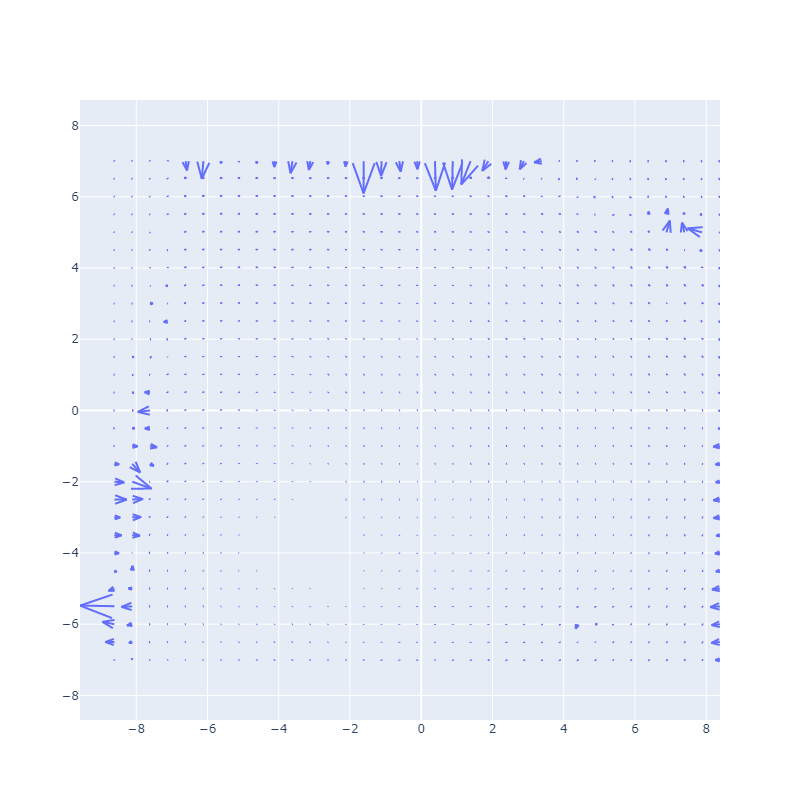

In [16]:
fig = ff.create_quiver(df['x'], df['y'], df['remainder_x'], df['remainder_y'],
                       scale=12,
                       arrow_scale=1,
                       line_width=2)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig.update_yaxes(
    scaleanchor="x",
    scaleratio=1,
  )
fig.show(figuretype)

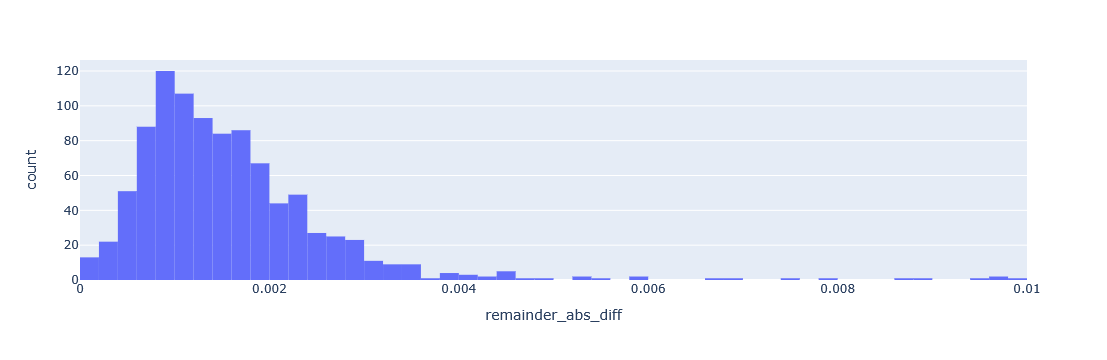

In [17]:
df['remainder_abs_diff'] = np.sqrt((tgtPts[:,0]-tgtPts_affine[:,0])**2 + (tgtPts[:,1]-tgtPts_affine[:,1])**2)
fig = px.histogram(df, x='remainder_abs_diff', nbins=500)
fig.update_xaxes(range=[0, 0.01])
fig.show()

# Combine all three affines to a single affine.

In [18]:
def reshape_affine(array_in):
    return np.array([[array_in[0], array_in[1],array_in[3]],
                     [array_in[4], array_in[5],array_in[7]],
                     [0.0, 0.0,1.0]])
affine1 = np.array(data['realTransform_0']['affinetransform3d'])
affine2 = np.array(data['realTransform_2']['affinetransform3d'])
affine1=reshape_affine(affine1)
affineTPS = np.vstack((affine.transpose(),[0.0, 0.0,1.0]))
affine2=reshape_affine(affine2)
print('Affine 1:')
print(affine1)
print('Affine TPS:')
print(affineTPS)
print('Affine 2:')
print(affine2)

Affine 1:
[[ 2.42534722e-04  0.00000000e+00 -8.38757830e+00]
 [ 0.00000000e+00  2.42647059e-04 -7.34723162e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Affine TPS:
[[ 1.00222904  0.00604829  0.37914349]
 [-0.0060593   1.00119664 -0.07091471]
 [ 0.          0.          1.        ]]
Affine 2:
[[1.97186899e+03 0.00000000e+00 1.63200000e+04]
 [0.00000000e+00 1.97186899e+03 1.41295000e+04]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [19]:
affine_c = np.dot(np.transpose(affine1), np.transpose(affineTPS))
affine_c = np.transpose(np.dot(affine_c, np.transpose(affine2)))
affine_c

array([[ 4.79312728e-01,  2.89391554e-03,  4.03922918e+02],
       [-2.89783973e-03,  4.79040765e-01, -4.15233369e+02],
       [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]])